# Projeto Disciplina KDD & Desafio Axondata

## Foco: Covid-19

### Ideia 2
Realizar agrupamentos de séries temporais relativas ao COVID-19, pra verificar quais países tem comportamentos similares em termos de casos confirmados, casos recuperados e óbitos. Agregar dados demográficos e analisar se isto impacta no agrupamento dos países.

Utiliza a base da JHU no formato Narrow, com as colunas de data já transformadas em linhas e colunas adicionais de identificação dos países e regiões (alpha_code, region_code, subregion_code e intermediateregion_code)

## Configuração Biblioteca e Spark

In [1]:
# importar bibliotecas necessárias
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window
from pyspark.sql.functions import col
import numpy as np
import pandas as pd
from fbprophet import Prophet

In [2]:
# criar contexto e configuração para o Spark
conf = SparkConf().setAppName("Covid-19 EDA")
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

## Explorar Dados - JHU (John Hopkins University)

In [3]:
# Schema para Ler os Dados da JHU - Narrow com alpha_code, region_code, subregion_code e intermediateregion_code
schema_jhu_narrow = StructType([StructField('province_state', StringType(), True),
                         StructField('country_region', StringType(), True),
                         StructField('lat', FloatType(), True),
                         StructField('long', FloatType(), True),
                         StructField('date', TimestampType(), True),
                         StructField('value', IntegerType(), True),
                         StructField('alpha_code', StringType(), True),
                         StructField('region_code', IntegerType(), True),
                         StructField('subregion_code', IntegerType(), True),
                         StructField('intermediateregion_code', IntegerType(), True)])

# ler arquivo de casos mundiais confirmados para dataframe Spark
confirmed_world_cases = sqlContext.read.csv('../datasets/time_series_covid19_confirmed_global_narrow.csv', sep=',', header=True, schema=schema_jhu_narrow)

# ler arquivo de casos recuperados mundiais para dataframe Spark
recovered_world_cases = sqlContext.read.csv('../datasets/time_series_covid19_recovered_global_narrow.csv', sep=',', header=True, schema=schema_jhu_narrow)

# ler arquivo de obitos mundiais para dataframe Spark
deaths_world_cases = sqlContext.read.csv('../datasets/time_series_covid19_deaths_global_narrow.csv', sep=',', header=True, schema=schema_jhu_narrow)

In [7]:
confirmed_world_cases.info()

AttributeError: 'DataFrame' object has no attribute 'info'

In [8]:
# verificar estrutura do dataframe de casos mundiais confirmados
confirmed_world_cases.printSchema()

root
 |-- province_state: string (nullable = true)
 |-- country_region: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- value: integer (nullable = true)
 |-- alpha_code: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- subregion_code: integer (nullable = true)
 |-- intermediateregion_code: integer (nullable = true)



In [9]:
# contagem de objetos de cada dataframe
print("Total de Objetos (base de infectados): {}".format(confirmed_world_cases.count()))
print("Total de Objetos (base de recuperados): {}".format(recovered_world_cases.count()))
print("Total de Objetos (base de óbitos): {}".format(deaths_world_cases.count()))

Total de Objetos (base de infectados): 22968
Total de Objetos (base de recuperados): 21750
Total de Objetos (base de óbitos): 22968


In [10]:
# renomear colunas do dataframe
# como estou usando um schema pros CSVs da JHU, trago todos com o campo Value e renomeio para o nome correto
confirmed_world_cases = confirmed_world_cases.withColumnRenamed("Value", "confirmed")
recovered_world_cases = recovered_world_cases.withColumnRenamed("Value", "recovered")
deaths_world_cases = deaths_world_cases.withColumnRenamed("Value", "deaths")

In [11]:
# Realizar o Merge dos Dataframes em um só - Narrow
join_condition_1 = [confirmed_world_cases.province_state.eqNullSafe(recovered_world_cases.province_state), \
                    confirmed_world_cases.date == recovered_world_cases.date, \
                    confirmed_world_cases.country_region == recovered_world_cases.country_region]

temp_df = confirmed_world_cases.join(recovered_world_cases, \
                                     on=join_condition_1, how="left") \
                                     .select(confirmed_world_cases.province_state, \
                                             confirmed_world_cases.country_region, \
                                             confirmed_world_cases.lat, \
                                             confirmed_world_cases.long, \
                                             confirmed_world_cases.date, \
                                             confirmed_world_cases.alpha_code, \
                                             confirmed_world_cases.region_code, \
                                             confirmed_world_cases.subregion_code, \
                                             confirmed_world_cases.intermediateregion_code,
                                             confirmed_world_cases.confirmed,
                                             recovered_world_cases.recovered)

join_condition_2 = [temp_df.province_state.eqNullSafe(deaths_world_cases.province_state), \
                    temp_df.date == deaths_world_cases.date, \
                    temp_df.country_region == deaths_world_cases.country_region]

complete_world_df = temp_df.join(deaths_world_cases, \
                                 on=join_condition_2, how="left") \
                                 .select(temp_df.province_state, \
                                         temp_df.country_region, \
                                         temp_df.lat, \
                                         temp_df.long, \
                                         temp_df.date, \
                                         temp_df.alpha_code, \
                                         temp_df.region_code, \
                                         temp_df.subregion_code, \
                                         temp_df.intermediateregion_code,
                                         temp_df.confirmed,
                                         temp_df.recovered,
                                         deaths_world_cases.deaths)

In [12]:
# Contagem de objetos do dataframe completo
print("Total de Objetos (base consolidada) : {}".format(complete_world_df.count()))

Total de Objetos (base consolidada) : 22968


In [13]:
# listar 10 primeiras linhas do dataframe
complete_world_df.limit(10).toPandas()

,province_state,country_region,lat,long,date,alpha_code,region_code,subregion_code,intermediateregion_code,confirmed,recovered,deaths
0,None,Afghanistan,33.0,65.0,2020-04-17,AFG,142,34,None,906,99,30
1,None,Afghanistan,33.0,65.0,2020-04-16,AFG,142,34,None,840,54,30
2,None,Afghanistan,33.0,65.0,2020-04-15,AFG,142,34,None,784,43,25
3,None,Afghanistan,33.0,65.0,2020-04-14,AFG,142,34,None,714,40,23
4,None,Afghanistan,33.0,65.0,2020-04-13,AFG,142,34,None,665,32,21
5,None,Afghanistan,33.0,65.0,2020-04-12,AFG,142,34,None,607,32,18
6,None,Afghanistan,33.0,65.0,2020-04-11,AFG,142,34,None,555,32,18
7,None,Afghanistan,33.0,65.0,2020-04-10,AFG,142,34,None,521,32,15
8,None,Afghanistan,33.0,65.0,2020-04-09,AFG,142,34,None,484,32,15
9,None,Afghanistan,33.0,65.0,2020-04-08,AFG,142,34,None,444,29,14


In [14]:
# remover linhas onde confirmed, recovered e deaths seja igual a zero
complete_world_df = complete_world_df.filter("confirmed != 0 and recovered != 0 and deaths != 0")

In [15]:
# Contagem de objetos do dataframe completo
print("Total de Objetos (base consolidada) : {}".format(complete_world_df.count()))

Total de Objetos (base consolidada) : 5988


In [16]:
# Criar coluna com qtde_dias desde o ínicio, pra cada país - Narrow
column_list = ['province_state', 'country_region']

complete_world_df = complete_world_df.select("province_state","country_region","lat", "long", "date", \
                                             "alpha_code", "region_code", "subregion_code", "intermediateregion_code", \
                                             "confirmed", "recovered", "deaths", F.row_number()\
                                             .over(Window.partitionBy([col(x) for x in column_list]) \
                                             .orderBy(complete_world_df['date'])).alias("num_days"))

In [17]:
# Estrutura Dataframe consolidado
complete_world_df.printSchema()

root
 |-- province_state: string (nullable = true)
 |-- country_region: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- alpha_code: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- subregion_code: integer (nullable = true)
 |-- intermediateregion_code: integer (nullable = true)
 |-- confirmed: integer (nullable = true)
 |-- recovered: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- num_days: integer (nullable = true)



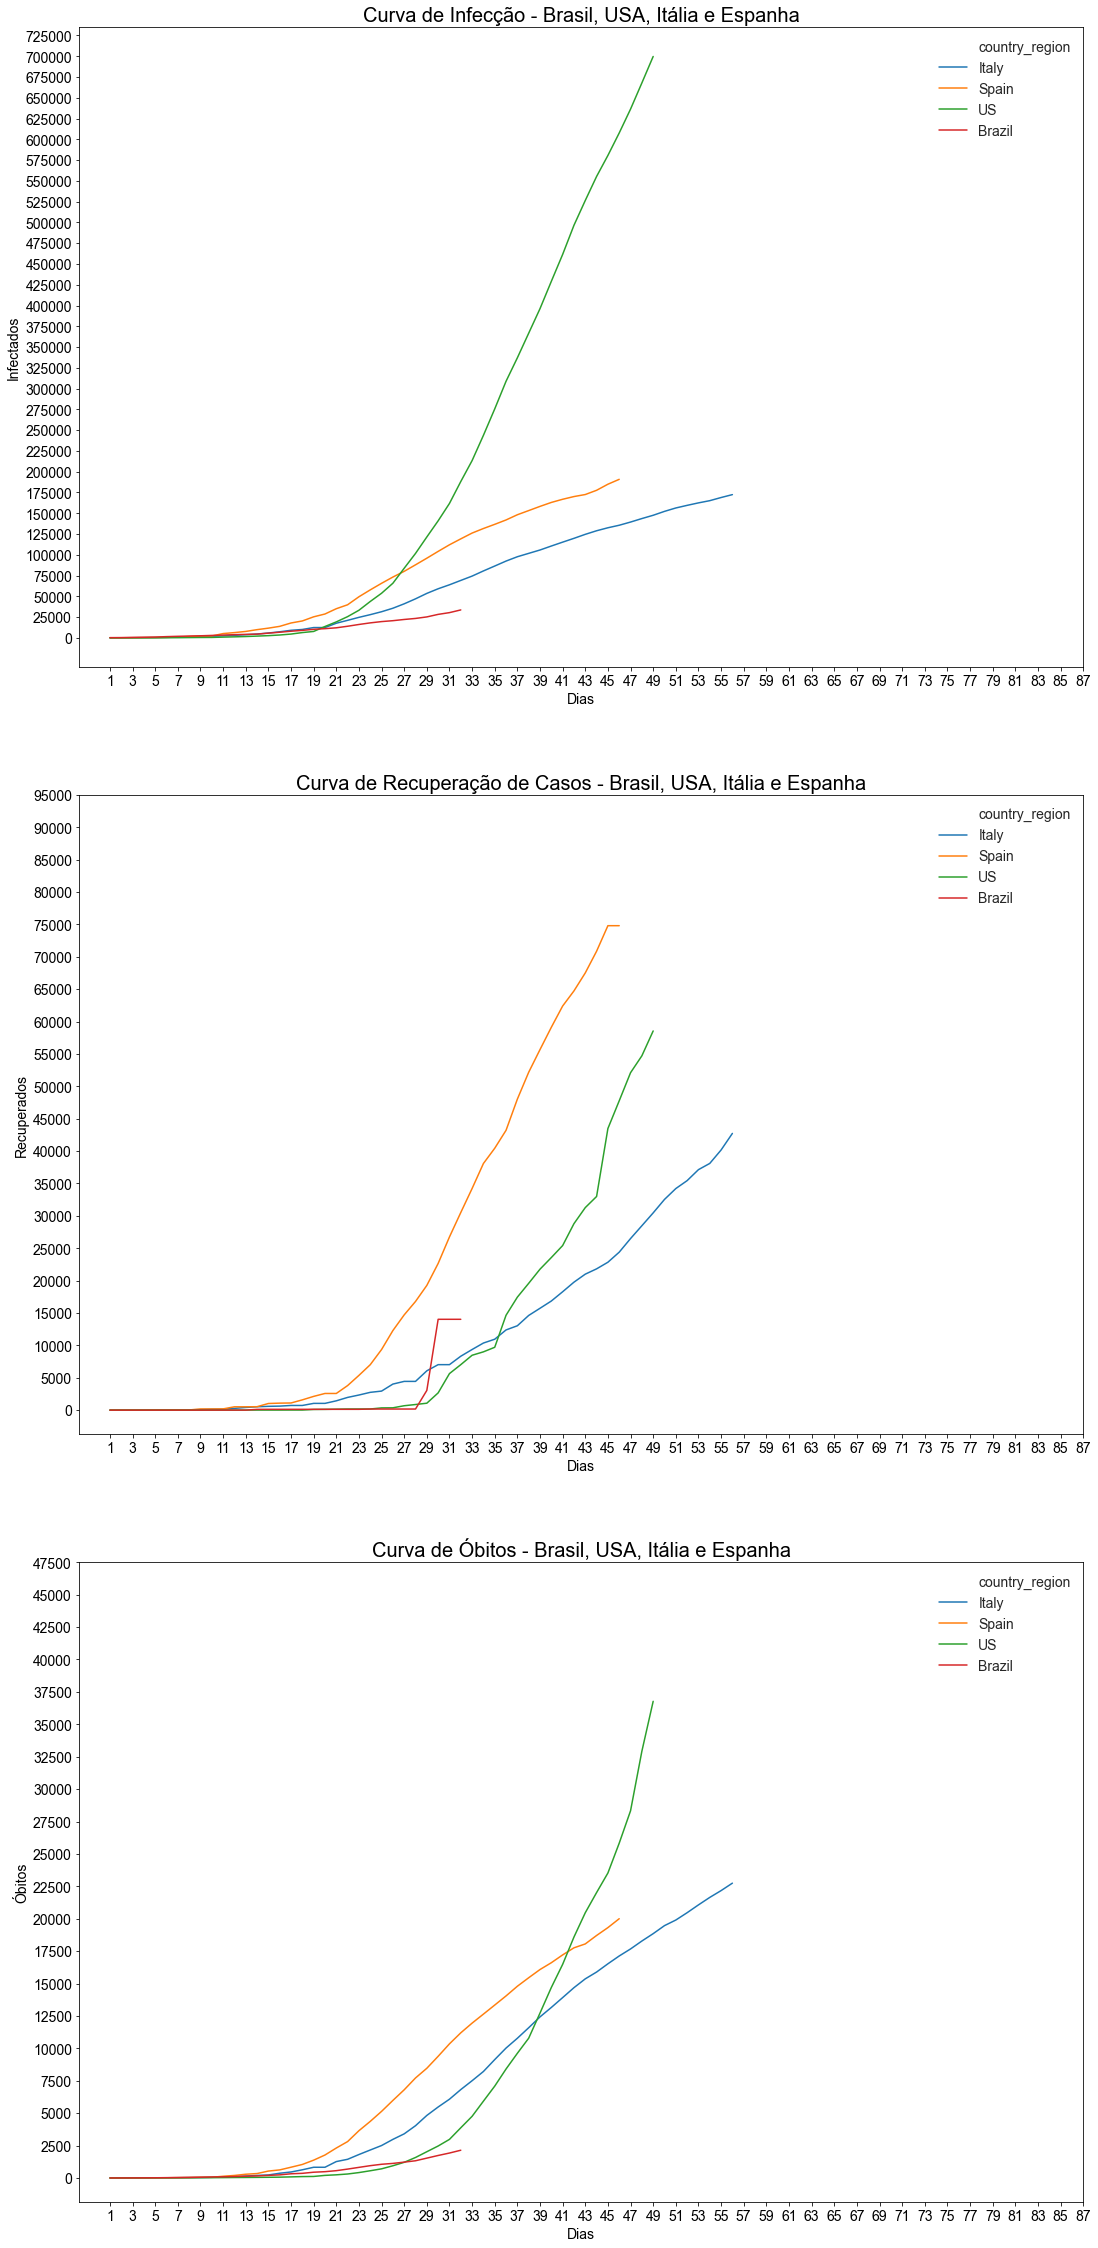

In [18]:
# Gerar gráficos comparando Brasil, Espanha, Italia e USA
fig_dims = (18, 40)
fig, ax = plt.subplots(figsize=fig_dims, nrows=3, ncols=1)
sns.set_style("darkgrid")

# Confirmados
sns.lineplot(x="num_days", y="confirmed", hue="country_region", ax=ax[0], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil", "Spain", "US", "Italy"])).toPandas())
ax[0].set_xticks(np.arange(1, 89, 2.0))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yticks(np.arange(0, 750000, 25000.0))
ax[0].legend(fontsize=14, frameon=False)
ax[0].set_xlabel("Dias", fontsize=14)
ax[0].set_ylabel("Infectados", fontsize=14)
ax[0].set_title("Curva de Infecção - Brasil, USA, Itália e Espanha", fontsize=20)

# Recuperados
sns.lineplot(x="num_days", y="recovered", hue="country_region", ax=ax[1], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil", "Spain", "US", "Italy"])).toPandas())
ax[1].set_xticks(np.arange(1, 89, 2.0))
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_yticks(np.arange(0, 100000, 5000.0))
ax[1].legend(fontsize=14, frameon=False)
ax[1].set_xlabel("Dias", fontsize=14)
ax[1].set_ylabel("Recuperados", fontsize=14)
ax[1].set_title("Curva de Recuperação de Casos - Brasil, USA, Itália e Espanha", fontsize=20)

# Óbitos
sns.lineplot(x="num_days", y="deaths", hue="country_region", ax=ax[2], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil", "Spain", "US", "Italy"])).toPandas())
ax[2].set_xticks(np.arange(1, 89, 2.0))
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].set_yticks(np.arange(0, 50000, 2500.0))
ax[2].legend(fontsize=14, frameon=False)
ax[2].set_xlabel("Dias", fontsize=14)
ax[2].set_ylabel("Óbitos", fontsize=14)
ax[2].set_title("Curva de Óbitos - Brasil, USA, Itália e Espanha", fontsize=20)

plt.show()

## Explorar Base de Dados - Brasil.io

In [20]:
# Schema para Ler os Dados dos Casos da Base Brasil.IO
schema_brasil_io = StructType([StructField('date', TimestampType(), True),
                        StructField('state', StringType(), True),
                        StructField('city', StringType(), True),
                        StructField('place_type', StringType(), True),
                        StructField('confirmed', IntegerType(), True),
                        StructField('deaths', IntegerType(), True),
                        StructField('num_days', IntegerType(), True),
                        StructField('is_last', BooleanType(), True),
                        StructField('estimated_population_2019', IntegerType(), True),
                        StructField('confirmed_by_100k_inhabitants', FloatType(), True),
                        StructField('death_rate', FloatType(), True)])

# ler arquivo de casos mundiais confirmados para dataframe Spark
brasil_io_cases = sqlContext.read.csv('../datasets/caso.csv', sep=',', header=True, schema=schema_brasil_io)

In [21]:
# Contagem de objetos do dataframe Brasil.io
print("Total de Objetos (base consolidada) : {}".format(brasil_io_cases.count()))

Total de Objetos (base consolidada) : 69395


In [22]:
# Estrutura Dataframe consolidado
brasil_io_cases.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- confirmed: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- num_days: integer (nullable = true)
 |-- is_last: boolean (nullable = true)
 |-- estimated_population_2019: integer (nullable = true)
 |-- confirmed_by_100k_inhabitants: float (nullable = true)
 |-- death_rate: float (nullable = true)



In [23]:
# listar 10 primeiras linhas do dataframe
brasil_io_cases.limit(10).toPandas()

,date,state,city,place_type,confirmed,deaths,num_days,is_last,estimated_population_2019,confirmed_by_100k_inhabitants,death_rate
0,2020-05-10,SE,None,state,1771,34,47,True,2298696,28.0,77.043678
1,2020-05-09,SE,None,state,1588,33,46,False,2298696,28.0,69.082649
2,2020-05-08,SE,None,state,1438,28,45,False,2298696,28.0,62.557209
3,2020-05-07,SE,None,state,1214,25,44,False,2298696,28.0,52.812550
4,2020-05-06,SE,None,state,998,23,43,False,2298696,28.0,43.415920
5,2020-05-05,SE,None,state,898,21,42,False,2298696,28.0,39.065632
6,2020-05-04,SE,None,state,772,17,41,False,2298696,28.0,33.584259
7,2020-05-03,SE,None,state,730,14,40,False,2298696,28.0,31.757139
8,2020-05-02,SE,None,state,601,14,39,False,2298696,28.0,26.145260
9,2020-05-01,SE,None,state,517,14,38,False,2298696,28.0,22.491011


In [24]:
# Ranking - Top 5 Cidades por Casos Confirmados
top_5_brasil_confirmed = brasil_io_cases.select('city','confirmed').filter("date == '2020-04-17' and place_type == 'city'").orderBy('confirmed', ascending=False).limit(5)
top_5_brasil_confirmed.show()

+--------------+---------+
|          city|confirmed|
+--------------+---------+
|     São Paulo|     8744|
|Rio de Janeiro|     2946|
|     Fortaleza|     2300|
|        Manaus|     1531|
|        Recife|     1136|
+--------------+---------+



In [25]:
# Ranking - Top 5 Cidades por Óbitos
top_5_brasil_deaths = brasil_io_cases.select('city','deaths').filter("date == '2020-04-17' and place_type == 'city'").orderBy('deaths', ascending=False).limit(5)
top_5_brasil_deaths.show()

+--------------+------+
|          city|deaths|
+--------------+------+
|     São Paulo|   643|
|Rio de Janeiro|   219|
|        Manaus|   127|
|     Fortaleza|   119|
|        Recife|    85|
+--------------+------+



In [26]:
# Cria filtro automatico de cidades para colocar no Gráfico

# filtro top 5 - casos confirmados
filter_confirmed_top5_cities = np.array(top_5_brasil_confirmed.select('city').collect(), dtype = 'object')
filter_confirmed_top5_cities = np.squeeze(filter_confirmed_top5_cities.reshape(filter_confirmed_top5_cities.shape[1], filter_confirmed_top5_cities.shape[0])).tolist()

# filtro top 5 - óbitos
filter_death_top5_cities = np.array(top_5_brasil_deaths.select('city').collect(), dtype = 'object')
filter_death_top5_cities = np.squeeze(filter_death_top5_cities.reshape(filter_death_top5_cities.shape[1], filter_death_top5_cities.shape[0])).tolist()

Text(0.5, 1.0, 'Curva de Óbitos - Top 5 Brasil')

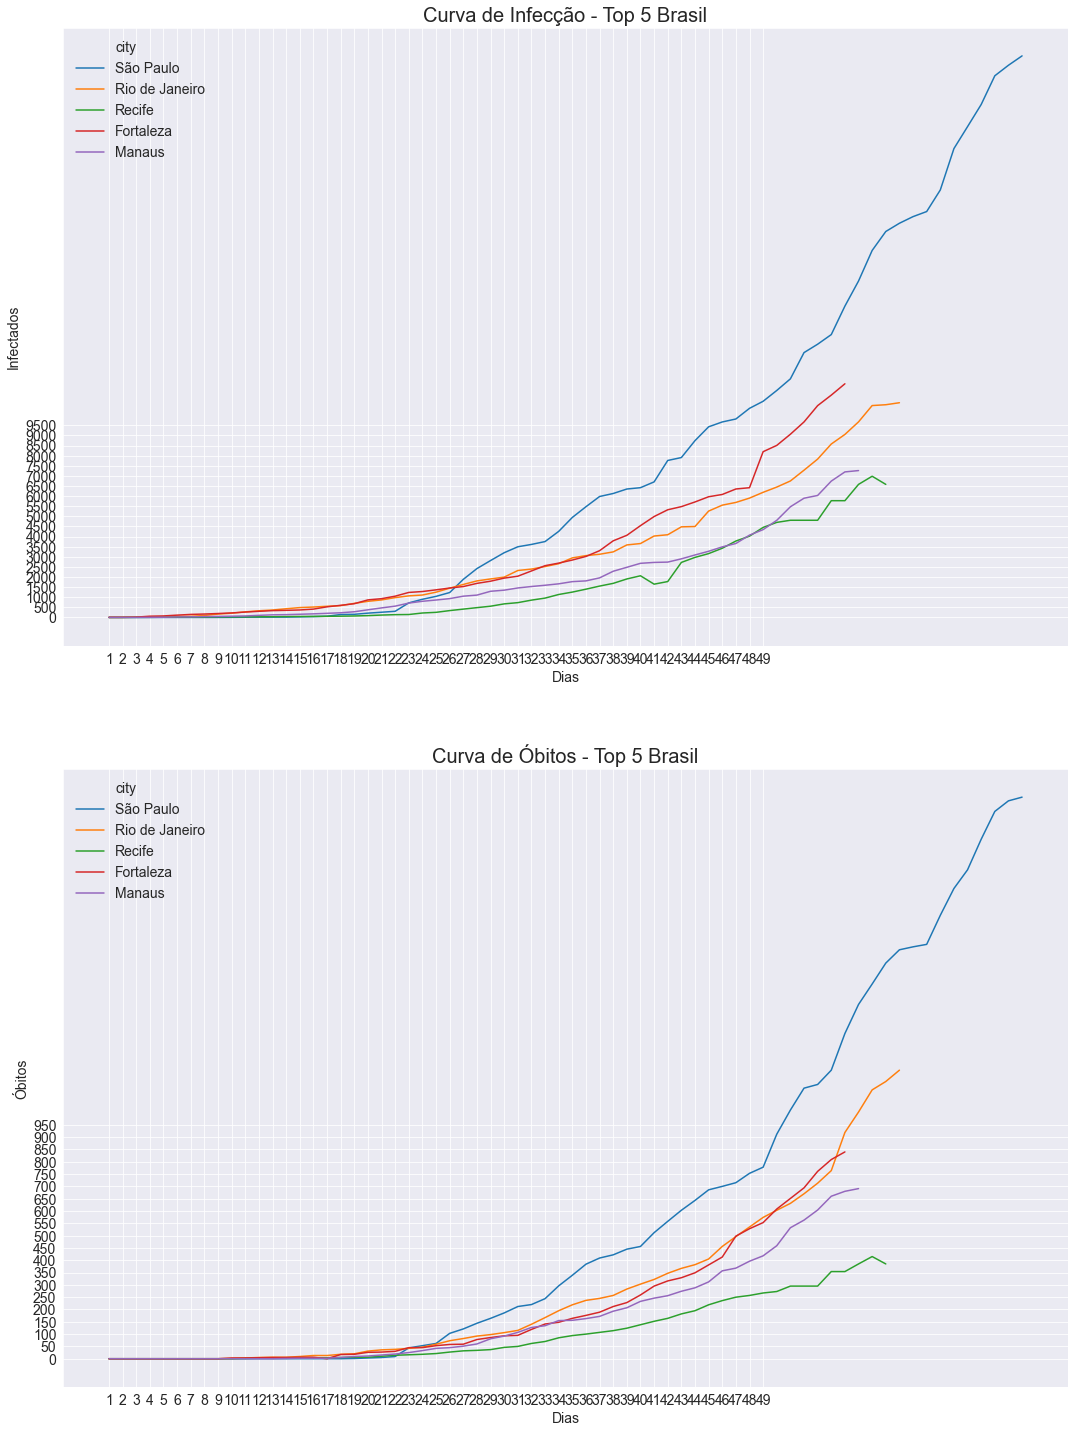

In [27]:
# Gerar gráficos comparando Top 5
fig_dims = (18, 25)
fig, ax = plt.subplots(figsize=fig_dims, nrows=2, ncols=1)
sns.set_style("darkgrid")

# Confirmados
sns.lineplot(x="num_days", y="confirmed", hue="city", ax=ax[0], data=brasil_io_cases.filter(brasil_io_cases.city.isin(filter_confirmed_top5_cities)).toPandas())
ax[0].set_xticks(np.arange(1, 50, 1.0))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yticks(np.arange(0, 10000, 500.0))
ax[0].legend(fontsize=14, frameon=False)
ax[0].set_xlabel("Dias", fontsize=14)
ax[0].set_ylabel("Infectados", fontsize=14)
ax[0].set_title("Curva de Infecção - Top 5 Brasil", fontsize=20)

# Óbitos
sns.lineplot(x="num_days", y="deaths", hue="city", ax=ax[1], data=brasil_io_cases.filter(brasil_io_cases.city.isin(filter_death_top5_cities)).toPandas())
ax[1].set_xticks(np.arange(1, 50, 1.0))
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_yticks(np.arange(0, 1000, 50.0))
ax[1].legend(fontsize=14, frameon=False)
ax[1].set_xlabel("Dias", fontsize=14)
ax[1].set_ylabel("Óbitos", fontsize=14)
ax[1].set_title("Curva de Óbitos - Top 5 Brasil", fontsize=20)

## Gerar Série Temporal para realizar previsões

In [28]:
# Criar Janela de Dados por País, Província e Numero de Dias (poderia ser a data também)
my_window = Window.partitionBy("country_region", "province_state").orderBy("num_days")

In [29]:
# Criar coluna para casos confirmados no dia
complete_world_df = complete_world_df.withColumn("prev_confirmed", F.lag(complete_world_df.confirmed).over(my_window))
complete_world_df = complete_world_df.withColumn("confirmed_day", F.when(F.isnull(complete_world_df.confirmed - complete_world_df.prev_confirmed), 0)
                              .otherwise(complete_world_df.confirmed - complete_world_df.prev_confirmed))

In [30]:
# Criar coluna para casos recuperados no dia
complete_world_df = complete_world_df.withColumn("prev_recovered", F.lag(complete_world_df.recovered).over(my_window))
complete_world_df = complete_world_df.withColumn("recovered_day", F.when(F.isnull(complete_world_df.recovered - complete_world_df.prev_recovered), 0)
                              .otherwise(complete_world_df.recovered - complete_world_df.prev_recovered))

In [31]:
# Criar coluna para óbitos no dia
complete_world_df = complete_world_df.withColumn("prev_deaths", F.lag(complete_world_df.deaths).over(my_window))
complete_world_df = complete_world_df.withColumn("deaths_day", F.when(F.isnull(complete_world_df.deaths - complete_world_df.prev_deaths), 0)
                              .otherwise(complete_world_df.deaths - complete_world_df.prev_deaths))

In [32]:
# Remover as colunas de lag
complete_world_df = complete_world_df.drop(*['prev_confirmed', 'prev_recovered', 'prev_deaths'])

In [33]:
# listar 10 primeiras linhas do dataframe
complete_world_df.limit(10).toPandas()

,province_state,country_region,lat,long,date,alpha_code,region_code,subregion_code,intermediateregion_code,confirmed,recovered,deaths,num_days,confirmed_day,recovered_day,deaths_day
0,Martinique,France,14.6415,-61.0242,2020-03-31,MTQ,19,419,29,128,27,3,1,0,0,0
1,Martinique,France,14.6415,-61.0242,2020-04-01,MTQ,19,419,29,135,27,3,2,7,0,0
2,Martinique,France,14.6415,-61.0242,2020-04-02,MTQ,19,419,29,138,27,3,3,3,0,0
3,Martinique,France,14.6415,-61.0242,2020-04-03,MTQ,19,419,29,143,27,3,4,5,0,0
4,Martinique,France,14.6415,-61.0242,2020-04-04,MTQ,19,419,29,145,27,3,5,2,0,0
5,Martinique,France,14.6415,-61.0242,2020-04-05,MTQ,19,419,29,149,50,4,6,4,23,1
6,Martinique,France,14.6415,-61.0242,2020-04-06,MTQ,19,419,29,151,50,4,7,2,0,0
7,Martinique,France,14.6415,-61.0242,2020-04-07,MTQ,19,419,29,152,50,4,8,1,0,0
8,Martinique,France,14.6415,-61.0242,2020-04-08,MTQ,19,419,29,154,50,6,9,2,0,2
9,Martinique,France,14.6415,-61.0242,2020-04-09,MTQ,19,419,29,154,50,6,10,0,0,0


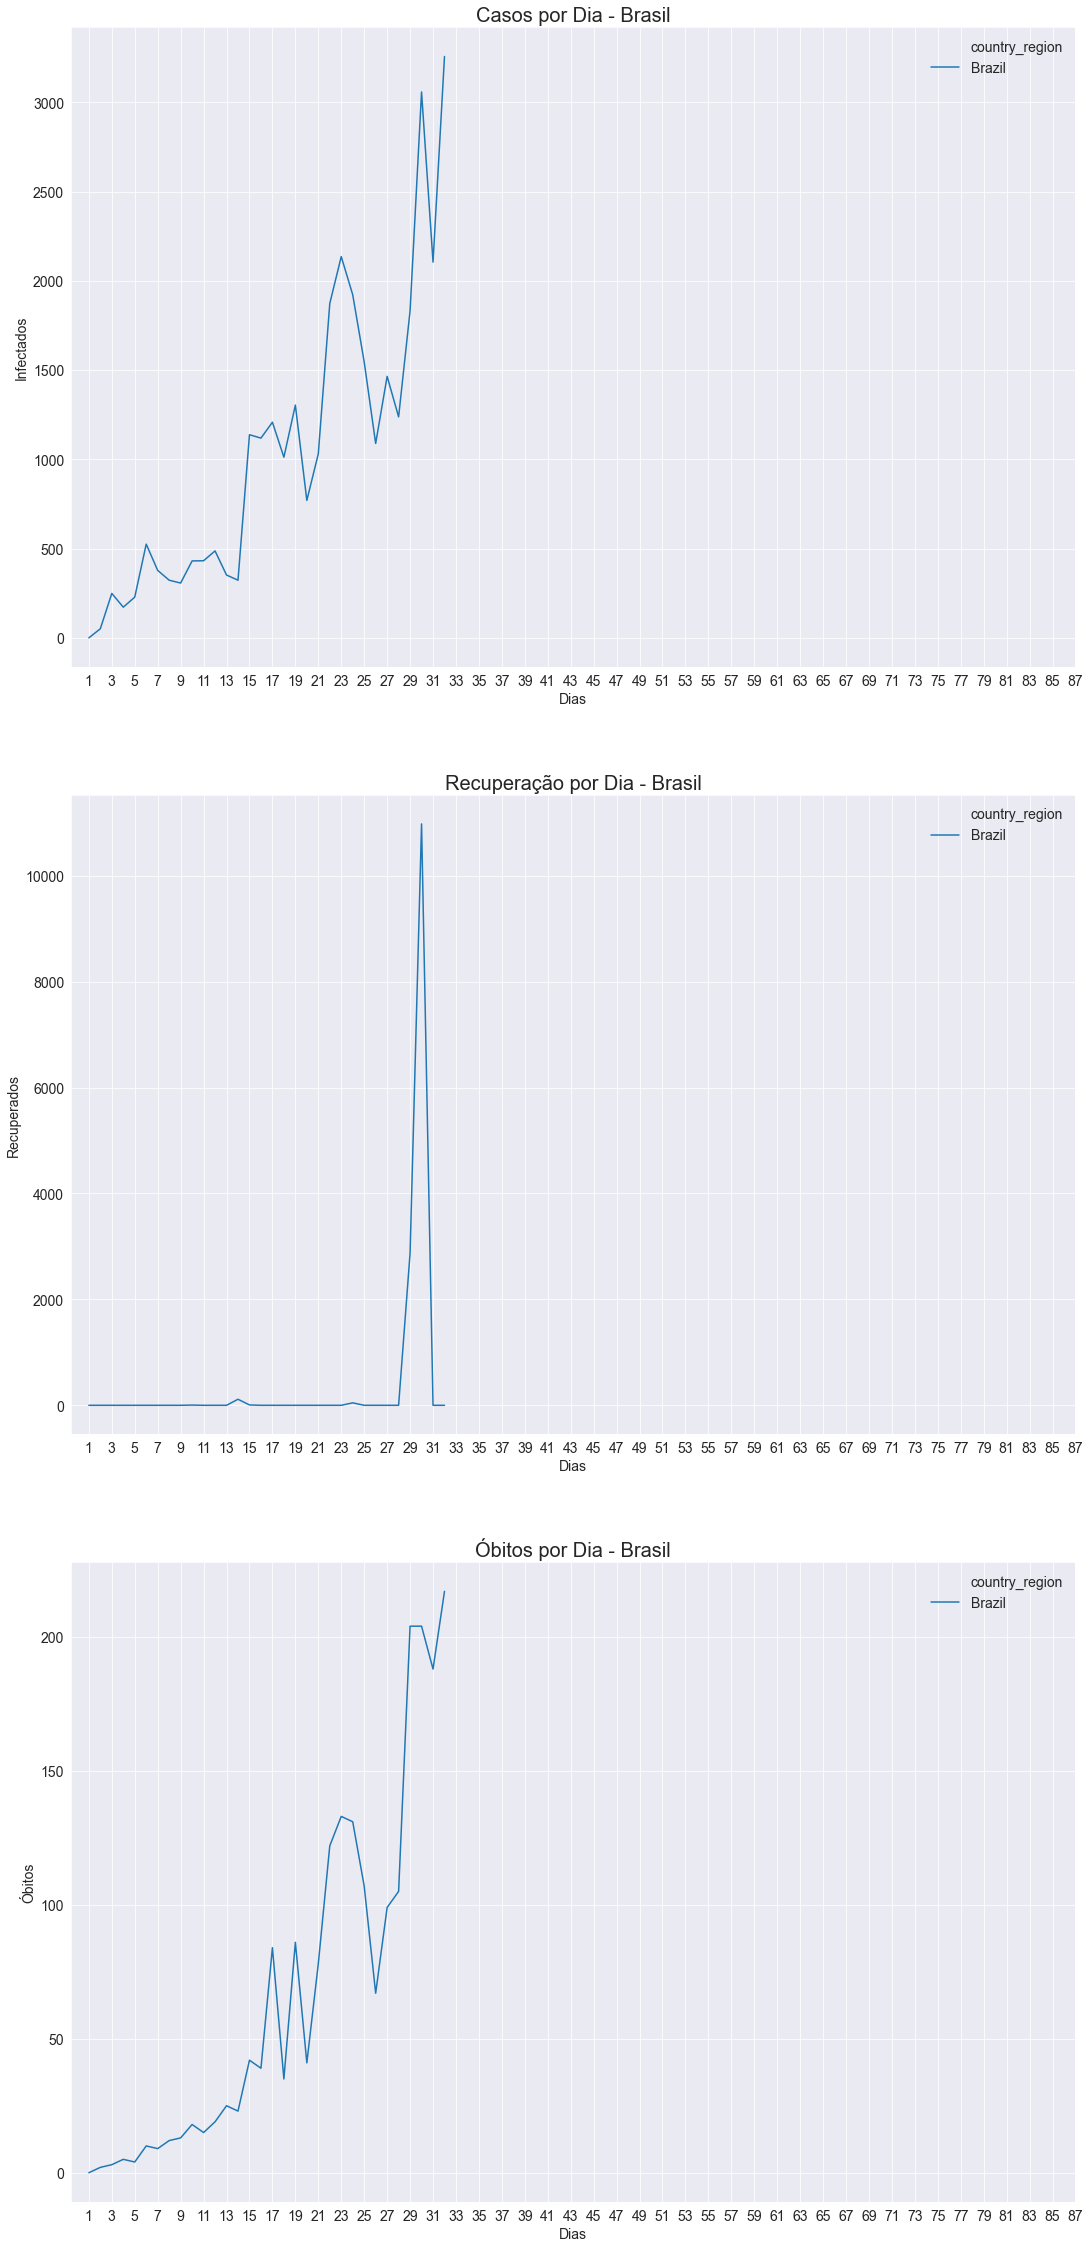

In [34]:
# Gerar gráficos Brasil, com posição diária
fig_dims = (18, 40)
fig, ax = plt.subplots(figsize=fig_dims, nrows=3, ncols=1)
sns.set_style("darkgrid")

# Confirmados
sns.lineplot(x="num_days", y="confirmed_day", hue="country_region", ax=ax[0], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil"])).toPandas())
ax[0].set_xticks(np.arange(1, 89, 2.0))
ax[0].tick_params(axis='both', which='major', labelsize=14)
#ax[0].set_yticks(np.arange(0, 750000, 25000.0))
ax[0].legend(fontsize=14, frameon=False)
ax[0].set_xlabel("Dias", fontsize=14)
ax[0].set_ylabel("Infectados", fontsize=14)
ax[0].set_title("Casos por Dia - Brasil", fontsize=20)

# Recuperados
sns.lineplot(x="num_days", y="recovered_day", hue="country_region", ax=ax[1], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil"])).toPandas())
ax[1].set_xticks(np.arange(1, 89, 2.0))
ax[1].tick_params(axis='both', which='major', labelsize=14)
#ax[1].set_yticks(np.arange(0, 100000, 5000.0))
ax[1].legend(fontsize=14, frameon=False)
ax[1].set_xlabel("Dias", fontsize=14)
ax[1].set_ylabel("Recuperados", fontsize=14)
ax[1].set_title("Recuperação por Dia - Brasil", fontsize=20)

# Óbitos
sns.lineplot(x="num_days", y="deaths_day", hue="country_region", ax=ax[2], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil"])).toPandas())
ax[2].set_xticks(np.arange(1, 89, 2.0))
ax[2].tick_params(axis='both', which='major', labelsize=14)
#ax[2].set_yticks(np.arange(0, 50000, 2500.0))
ax[2].legend(fontsize=14, frameon=False)
ax[2].set_xlabel("Dias", fontsize=14)
ax[2].set_ylabel("Óbitos", fontsize=14)
ax[2].set_title("Óbitos por Dia - Brasil", fontsize=20)

plt.show()

In [35]:
# Verificar Brasil
complete_world_df.filter(complete_world_df.country_region.isin(["Brazil"])).toPandas()

,province_state,country_region,lat,long,date,alpha_code,region_code,subregion_code,intermediateregion_code,confirmed,recovered,deaths,num_days,confirmed_day,recovered_day,deaths_day
0,None,Brazil,-14.235,-51.925301,2020-03-17,BRA,19,419,5,321,2,1,1,0,0,0
1,None,Brazil,-14.235,-51.925301,2020-03-18,BRA,19,419,5,372,2,3,2,51,0,2
2,None,Brazil,-14.235,-51.925301,2020-03-19,BRA,19,419,5,621,2,6,3,249,0,3
3,None,Brazil,-14.235,-51.925301,2020-03-20,BRA,19,419,5,793,2,11,4,172,0,5
4,None,Brazil,-14.235,-51.925301,2020-03-21,BRA,19,419,5,1021,2,15,5,228,0,4
5,None,Brazil,-14.235,-51.925301,2020-03-22,BRA,19,419,5,1546,2,25,6,525,0,10
6,None,Brazil,-14.235,-51.925301,2020-03-23,BRA,19,419,5,1924,2,34,7,378,0,9
7,None,Brazil,-14.235,-51.925301,2020-03-24,BRA,19,419,5,2247,2,46,8,323,0,12
8,None,Brazil,-14.235,-51.925301,2020-03-25,BRA,19,419,5,2554,2,59,9,307,0,13
9,None,Brazil,-14.235,-51.925301,2020-03-26,BRA,19,419,5,2985,6,77,10,431,4,18


## Forecast usando Facebook Prophet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


Previsão Confirmados: 10 dias
           ds         yhat   yhat_lower   yhat_upper
32 2020-04-18  2167.696437  1751.818423  2585.707485
33 2020-04-19  2168.960967  1780.190532  2580.466297
34 2020-04-20  2133.791212  1728.117702  2533.124599
35 2020-04-21  2701.429427  2290.897443  3121.602169
36 2020-04-22  3002.206367  2582.507912  3428.701479
37 2020-04-23  2851.508234  2443.746866  3225.839738
38 2020-04-24  2952.410088  2527.258023  3370.297954
39 2020-04-25  2723.435741  2311.288055  3112.515100
40 2020-04-26  2724.700271  2307.640691  3119.191615
41 2020-04-27  2689.530516  2276.584718  3119.061453


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


Previsão Recuperados: 10 dias
           ds         yhat   yhat_lower   yhat_upper
32 2020-04-18  1258.494455  -799.500528  3328.420832
33 2020-04-19  1258.495663  -805.248307  3300.926416
34 2020-04-20  1287.002593  -738.910256  3572.331694
35 2020-04-21  2086.298673    17.985615  4176.954504
36 2020-04-22  3706.630399  1635.533907  5816.157042
37 2020-04-23  1520.185044  -717.120711  3582.640149
38 2020-04-24  1510.183968  -558.157816  3798.516769
39 2020-04-25  1761.880445  -376.820400  3873.691364
40 2020-04-26  1761.881653  -490.581700  3856.658647
41 2020-04-27  1790.388583  -450.853310  3817.362007


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


Previsão Óbitos: 10 dias
           ds        yhat  yhat_lower  yhat_upper
32 2020-04-18  156.679812  127.779645  187.276717
33 2020-04-19  156.435639  124.852349  186.598155
34 2020-04-20  166.426877  135.123785  196.063652
35 2020-04-21  211.158612  179.655472  239.388700
36 2020-04-22  213.360840  181.508013  245.508040
37 2020-04-23  219.956635  187.696858  249.753650
38 2020-04-24  210.974587  178.285612  242.745104
39 2020-04-25  201.743523  170.427017  231.488271
40 2020-04-26  201.499351  171.368159  234.095289
41 2020-04-27  211.490589  178.698813  241.408827


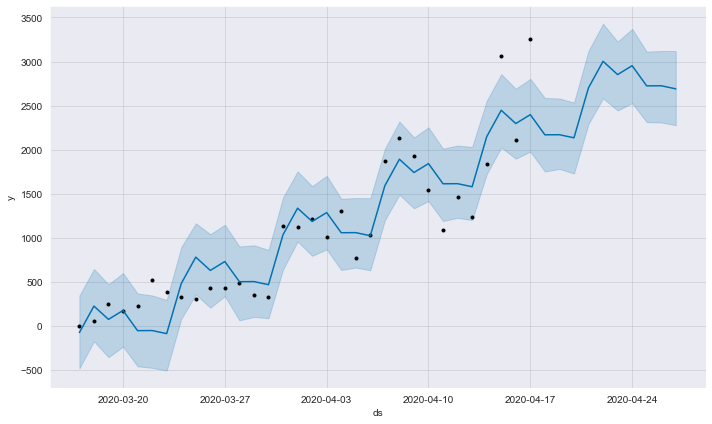

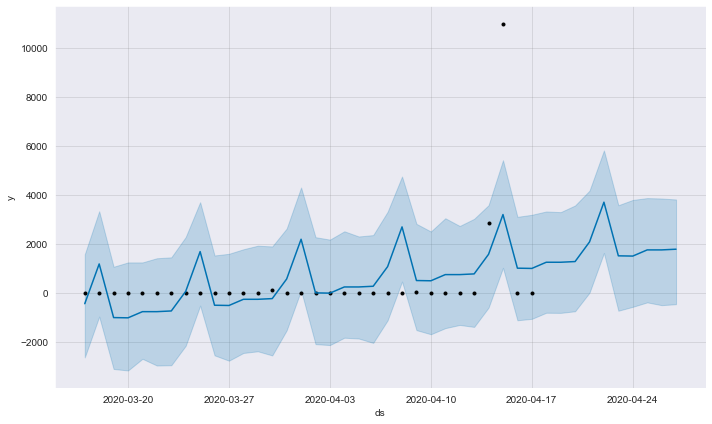

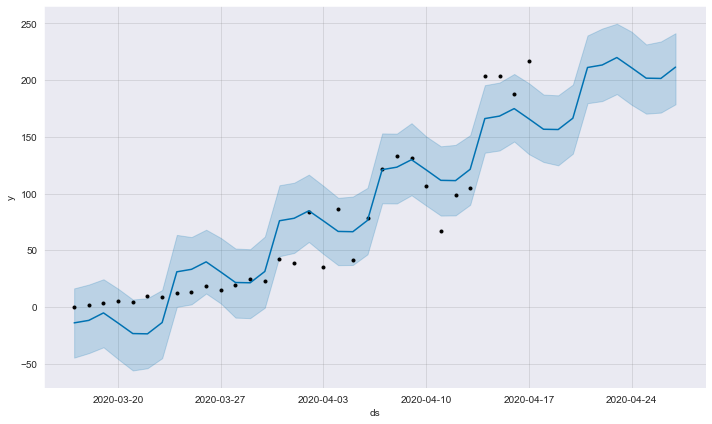

In [36]:
# confirmados
X = complete_world_df.selectExpr('date as ds', 'confirmed_day as y').filter(complete_world_df.country_region.isin(["Brazil"])).toPandas()
model_confirmed = Prophet()
model_confirmed.fit(X)
future_confirmed_brazil = model_confirmed.make_future_dataframe(periods=10)
forecast_confirmed_brazil = model_confirmed.predict(future_confirmed_brazil)
print('Previsão Confirmados: 10 dias')
print(forecast_confirmed_brazil[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

# recuperados
X = complete_world_df.selectExpr('date as ds', 'recovered_day as y').filter(complete_world_df.country_region.isin(["Brazil"])).toPandas()
model_recovered = Prophet()
model_recovered.fit(X)
future_recovered_brazil = model_recovered.make_future_dataframe(periods=10)
forecast_recovered_brazil = model_recovered.predict(future_recovered_brazil)
print('Previsão Recuperados: 10 dias')
print(forecast_recovered_brazil[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

# óbitos
X = complete_world_df.selectExpr('date as ds', 'deaths_day as y').filter(complete_world_df.country_region.isin(["Brazil"])).toPandas()
model_deaths = Prophet()
model_deaths.fit(X)
future_deaths_brazil = model_deaths.make_future_dataframe(periods=10)
forecast_deaths_brazil = model_deaths.predict(future_deaths_brazil)
print('Previsão Óbitos: 10 dias')
print(forecast_deaths_brazil[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

# Gráficos Forecast FBProphet
fig1 = model_confirmed.plot(forecast_confirmed_brazil)
fig2 = model_recovered.plot(forecast_recovered_brazil)
fig3 = model_deaths.plot(forecast_deaths_brazil)

## Datasets COVID19

- https://data.brasil.io/dataset/covid19/_meta/list.html
- https://github.com/CSSEGISandData/COVID-19
- https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
- https://github.com/beoutbreakprepared/nCoV2019?files=1
- https://www.kaggle.com/smid80/coronavirus-covid19-tweets
- https://www.kaggle.com/paultimothymooney/covid19-containment-and-mitigation-measures
- https://www.kaggle.com/unanimad/corona-virus-brazil
- https://docs.google.com/spreadsheets/d/1-kTZJZ1GAhJ2m4GAIhw1ZdlgO46JpvX0ZQa232VWRmw/edit#gid=2034285255
- https://github.com/github/covid-19-repo-data
- https://github.com/datasets/covid-19
- https://github.com/pomber/covid19
- https://github.com/joachim-gassen/tidy_covid19

## Dados Demográficos (Brasil e Mundo)

- https://data.worldbank.org/indicator/sp.pop.totl
- https://www.kaggle.com/crisparada/brazilian-cities
- https://www.kaggle.com/fernandol/countries-of-the-world

## Artigos, estudos e recursos - COVID-19
- https://medium.com/data-for-science/epidemic-modeling-101-or-why-your-covid19-exponential-fits-are-wrong-97aa50c55f8
- https://medium.com/data-for-science/epidemic-modeling-102-all-covid-19-models-are-wrong-but-some-are-useful-c81202cc6ee9
- https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html
- https://medium.com/@flohagenbuch/vemos-luz-no-fim-do-túnel-covid-19-96663d3cf1ed
- https://investnews.com.br/cafeina/novo-estudo-contesta-previsoes-sobre-mortes-pela-covid-19-no-brasil/
- https://science.sciencemag.org/content/early/2020/04/14/science.abb5793.full
- https://www.medrxiv.org/content/10.1101/2020.02.27.20028027v3
- https://towardsdatascience.com/5-datasets-about-covid-19-you-can-use-right-now-46307b1406a?gi=8f8a40a7b45b
- https://www.kaggle.com/brandao/covid19-reduzindo-falsos-negativos
- https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions
- https://towardsdatascience.com/top-5-r-resources-on-covid-19-coronavirus-1d4c8df6d85f

## Papers, Estudos, Artigos - Séries Temporais
- https://peerj.com/preprints/3190/